# Road Sign detection model

In [149]:
# useful libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

print('Tensorflow version :', tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

%matplotlib inline

Tensorflow version : 2.4.0
Num GPUs Available:  1


### Load the data and check shapes (summary of the data set)

In [150]:
# load data
with open("train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)
  
# label and features
x_train, y_train = train['features'], train['labels']
x_validation, y_validation = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

In [151]:
# check the shape of the data
x_shape = x_train.shape
y_shape = y_train.shape
x_val_shape = x_validation.shape
y_val_shape = y_validation.shape

print("Features shape :", x_shape)
print("Validation features shape :", x_val_shape)
print("Labels shape :", y_shape)
print("Validation labels shape :", y_val_shape)

Features shape : (34799, 32, 32, 3)
Validation features shape : (4410, 32, 32, 3)
Labels shape : (34799,)
Validation labels shape : (4410,)


In [152]:
# Number of training examples
num_train = x_train.shape[0]

# Number of validation examples
num_validation = x_validation.shape[0]

# Number of testing examples.
num_test = x_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = x_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", num_train)
print("Number of validation examples =", num_validation)
print("Number of testing examples =", num_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Group the image by class labels.

We will group the images by label.

In [153]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)
x_validation, y_validation = shuffle(x_validation, y_validation)
x_test, y_test = shuffle(x_test, y_test)

### Convert to grayscale and normalization of the data


In [154]:
# convert color images to grayscale using averaging method (np.sum)
x_train_gray = np.sum(x_train, axis=3, keepdims=True)/3
x_test_gray  = np.sum(x_test, axis=3, keepdims=True)/3
x_validation_gray  = np.sum(x_validation, axis=3, keepdims=True)/3

# normalization of the data
x_train_gray -= np.mean(x_train_gray, axis=0)
x_test_gray -= np.mean(x_test_gray, axis=0)
x_validation_gray -= np.mean(x_train_gray, axis=0)

x_train_gray /= (np.std(x_train_gray, axis=0) + np.finfo('float32').eps)
x_test_gray /= (np.std(x_test_gray, axis=0) + np.finfo('float32').eps)
x_validation_gray /= (np.std(x_validation_gray, axis=0) + np.finfo('float32').eps)

# one-hot encoding classes
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
#y_validation = to_categorical(y_validation)

### Display the images

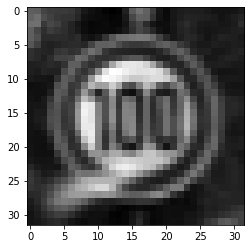

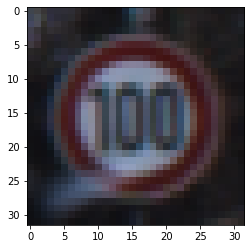

In [155]:
i = 610
plt.imshow(x_train_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(x_train[i])

### Model architecture

After normalization of the data, we've one-hot encoded the 43 different classes of road signs. Now we'll define a model architecture to train our network and to prevent overfitting.

In [156]:
from tensorflow.keras import regularizers

# Model architecture
def cnn_model_architecture(kernel_size, input_shape):
            
    cnn_model = tf.keras.Sequential()
           
    cnn_model.add(layers.Conv2D(32, kernel_size, activation = 'relu', input_shape=input_shape)) 
    cnn_model.add(layers.Conv2D(64, kernel_size, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape))      
    cnn_model.add(layers.MaxPooling2D(pool_size=(2,2))) 
    cnn_model.add(layers.Dropout(0.25))
    cnn_model.add(layers.Conv2D(128, kernel_size, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape)) 
    cnn_model.add(layers.MaxPooling2D(pool_size=(2,2)))        
    cnn_model.add(layers.Dropout(0.5))

    cnn_model.add(layers.Flatten())   
    cnn_model.add(layers.Dropout(0.25)) 
    cnn_model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
    cnn_model.add(layers.Dropout(0.5))   
    cnn_model.add(layers.Dense(n_classes, activation='softmax'))
    
    return cnn_model   

In [157]:
# Compiling the model 
def compile_model():
    cnn_model_architecture(kernel_size, input_shape)    
    cnn_model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['acc'])
    return cnn_model

In [158]:
# using callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<0.45):
      print("\nReached 0.45 validation loss so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

### Compile the model

In [159]:
kernel_size = (3,3)
input_shape = x_train_gray[1].shape
batch_size = 348
epochs = 70

cnn_model = cnn_model_architecture(kernel_size, input_shape)
cnn_model = compile_model()

### Train and evaluate the model

In [160]:
def train_model(model, x_train, y_train, x_validation, y_validation, batch_size, epochs, callbacks):   

    # train the model    
    model_history = model.fit(x_train,
                        y_train,
                        batch_size= batch_size,
                        epochs = epochs, 
                        steps_per_epoch = len(x_train) / batch_size,
                        verbose=1, 
                        validation_data= (x_validation, y_validation),
                        callbacks=[callbacks])
    
    return model_history


In [161]:
# train and evaluate the model
history = train_model(cnn_model,
                      x_train_gray, 
                      y_train, 
                      x_validation_gray, 
                      y_validation,
                      batch_size,
                      epochs,
                      callbacks)    

Epoch 1/70
99/99 [==============================] - 3s 28ms/step - loss: 3.5790 - acc: 0.1961 - val_loss: 1.5367 - val_acc: 0.7639
Epoch 2/70
99/99 [==============================] - 3s 26ms/step - loss: 1.1437 - acc: 0.7848 - val_loss: 1.0153 - val_acc: 0.8841
Epoch 3/70
99/99 [==============================] - 3s 26ms/step - loss: 0.7832 - acc: 0.8972 - val_loss: 0.8329 - val_acc: 0.9166
Epoch 4/70
99/99 [==============================] - 3s 26ms/step - loss: 0.6745 - acc: 0.9252 - val_loss: 0.7837 - val_acc: 0.9234
Epoch 5/70
99/99 [==============================] - 3s 26ms/step - loss: 0.5885 - acc: 0.9445 - val_loss: 0.7076 - val_acc: 0.9317
Epoch 6/70
99/99 [==============================] - 3s 26ms/step - loss: 0.5568 - acc: 0.9470 - val_loss: 0.6967 - val_acc: 0.9293
Epoch 7/70
99/99 [==============================] - 3s 26ms/step - loss: 0.5157 - acc: 0.9544 - val_loss: 0.6794 - val_acc: 0.9286
Epoch 8/70
99/99 [==============================] - 3s 26ms/step - loss: 0.4861 - a

In [162]:
# evaluate the model
score = cnn_model.evaluate(x_test_gray, y_test, verbose=0)
print('\nTest loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))


Test loss : 0.3919
Test Accuracy : 0.9652


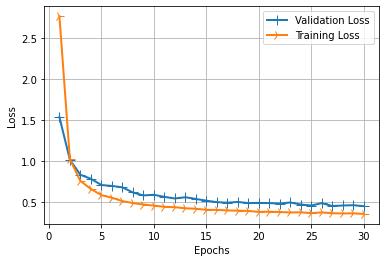

In [163]:
# plot loss _values
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+ 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation Loss')
line2 = plt.plot(epochs, loss_values, label= 'Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker= '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

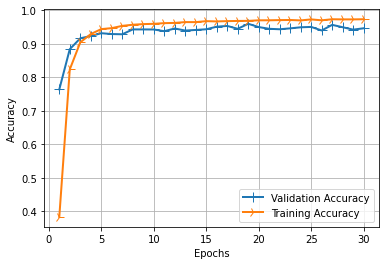

In [164]:
# plot accuracy 

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values)+ 1)
line1 = plt.plot(epochs, val_acc_values, label = 'Validation Accuracy')
line2 = plt.plot(epochs, acc_values, label= 'Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker= '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [165]:
#Printing the classification report
from sklearn.metrics import classification_report
predictions = cnn_model.predict_classes(x_test_gray)
print(classification_report(y_test,predictions))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.98      0.98      0.98       720
           2       0.96      0.99      0.98       750
           3       0.97      0.94      0.95       450
           4       0.99      0.98      0.99       660
           5       0.93      0.95      0.94       630
           6       1.00      0.83      0.91       150
           7       0.96      0.92      0.94       450
           8       0.92      0.98      0.95       450
           9       0.96      1.00      0.98       480
          10       0.99      1.00      0.99       660
          11       0.93      1.00      0.96       420
          12       0.94      0.98      0.96       690
          13       0.99      1.00      0.99       720
          14       1.00      0.99      1.00       270
          15       0.98      1.00      0.99       210
          16       1.00      0.99      0.99       150
          17       0.99    

In [166]:
# save model
cnn_model.save("./road_sign_model_31_12_7.h5")

In [167]:
%%javascript
<!-- Save the notebook -->
IPython.notebook.save_checkpoint();

<IPython.core.display.Javascript object>